In [1]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
import boto3
from typing import List
from pathlib import Path
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss

In [2]:
def get_df_params_drift(filepath: str, level_folders: List[str], s3: bool, bucket: str)->pd.DataFrame:
    """
    Loop over k_fold folders and extract drifts

    Args:
        filepath (str): path to k_fold folders
        level_folders (List[str]): folder names to loop for
        s3: AWS S3 flag
        bucket: S3 bucket name

    Returns:
        pd.DataFrame: _description_
    """
    
    # subpath to the cvs log file
    subpath = "logs/csv/version_0/metrics.csv"
    
    # drift columns to save
    cols = [
        "epoch",
        "encoder_variable_row_drift_active",
        "encoder_position_row_drift_active",
        "final_ff_whole_drift"
        ]
    
    s3_client = boto3.client("s3") if s3 else None
    
    # initialize empty df
    df_out = None
    
    # loop over the bottom folders
    for case in level_folders:
        
        # update internal filepath
        filepath_ = join(filepath,case,subpath)
        full_path = join(filepath, case, subpath).replace("\\", "/")

        
        if s3:
            try:
                obj = s3_client.get_object(Bucket=bucket, Key=full_path)
                df_k = pd.read_csv(StringIO(obj["Body"].read().decode("utf-8")))[cols].dropna()
            except Exception as e:
                print(f"Failed to read {full_path} from S3: {e}")
                continue
        else:
            df_k = pd.read_csv(filepath_)[cols].dropna()
        
        df_k["k"] = case
        
        if df_out is None:
            df_out = df_k
        else:
            df_out = pd.concat([df_out,df_k])
    
    return df_out



def debug_opt_mk_plot(dirpath: Path, s3_bool):
    
    df_drift = get_df_recursive(filepath=dirpath, bottom_action=get_df_params_drift, is_bottom= has_logs_subfolder, s3=s3_bool, bucket="experiments-private")
    df_loss = get_df_recursive(filepath=dirpath, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder, s3=s3_bool, bucket="experiments-private") 

    df_loss["sweep_val"] = df_loss["level_2"].str.extract(r"([-+]?\d*\.\d+)")
    df_loss_plot = pd.melt(df_loss, value_vars=["val_loss", "train_loss", "test_loss"],var_name="loss",id_vars="sweep_val")

    cols = [
        "encoder_variable_row_drift_active",
        "encoder_position_row_drift_active",
        "final_ff_whole_drift"
    ]

    fig = plt.figure(figsize=(6*(len(cols)+1), 5))
    gs = gridspec.GridSpec(1, len(cols)+1)

    for i,col in enumerate(cols):
        ax = fig.add_subplot(gs[i])
        sns.lineplot(data=df_drift, x="epoch", y=col, hue="level_2", palette="tab10", ax=ax)
        ax.grid(True)

    ax = ax = fig.add_subplot(gs[-1])
    sns.pointplot(data=df_loss_plot, x="sweep_val", y="value", hue="loss", errorbar="sd", ax=ax)
    ax.grid(True)
    
    plt.show()


 Mode  |Phase  | Model Optimizer | Enc. Emb. Opt. 
-------|-------|-----------------|---------------
 1     | NA    | Adam(base_lr)   | Adam(base_lr)
 2     | NA    | Adam(base_lr)   | Adam(emb_lr)
 3     | NA    | Adam(base_lr)   | SparseAdam(emb_lr)
 4     | NA    | Adam(base_lr)   | Adagrad(emb_lr)

## Summation Embeddings

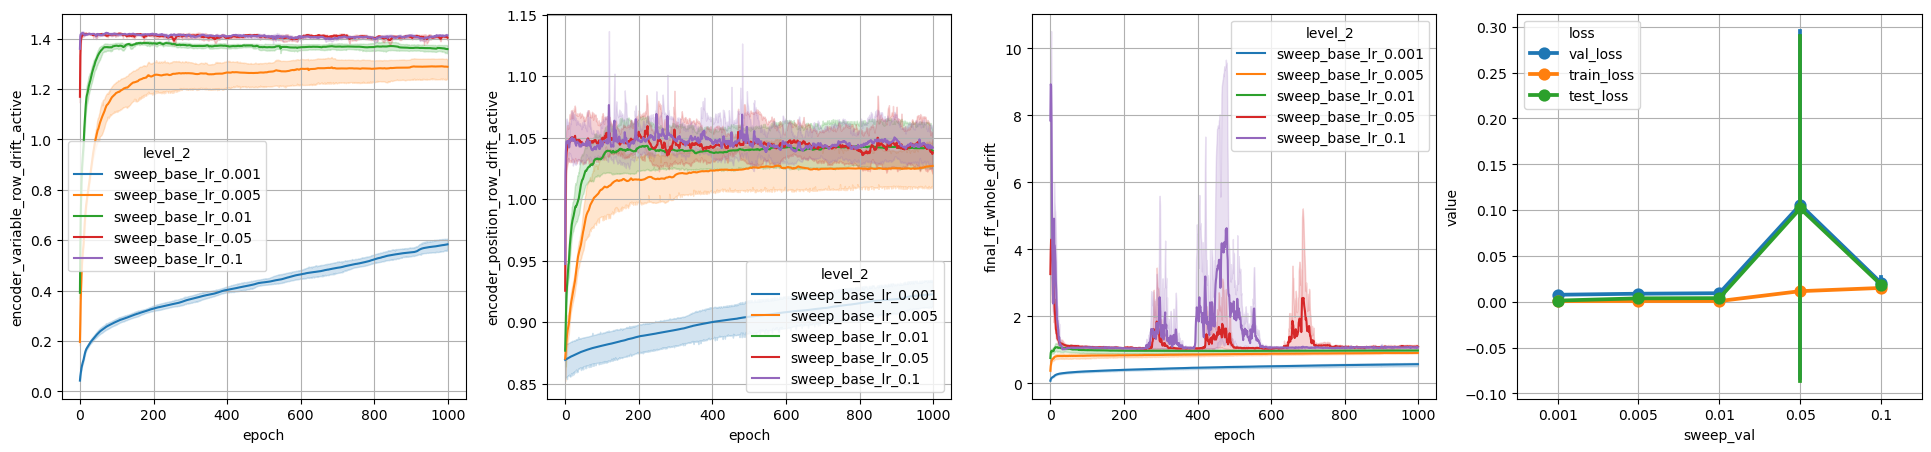

In [3]:
exp_path = "proT/optimizer_experiments/test_opt1_sum/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

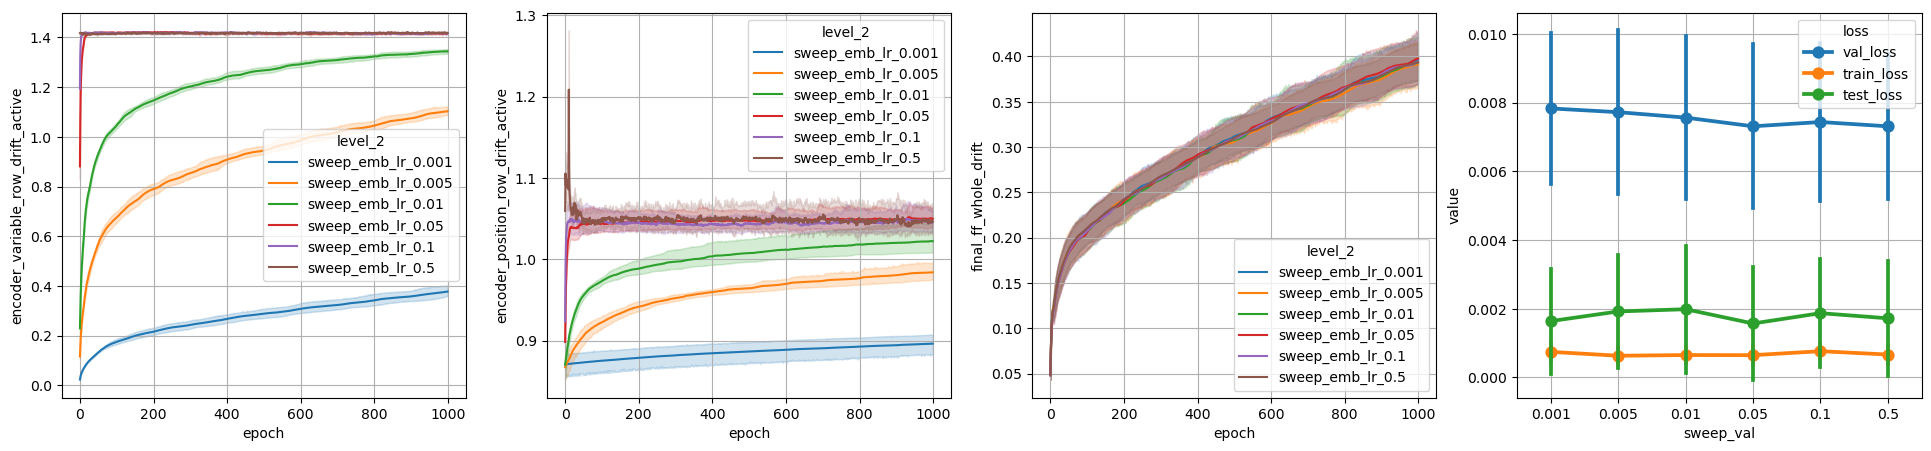

In [4]:
exp_path = "proT/optimizer_experiments/test_opt2_sum/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

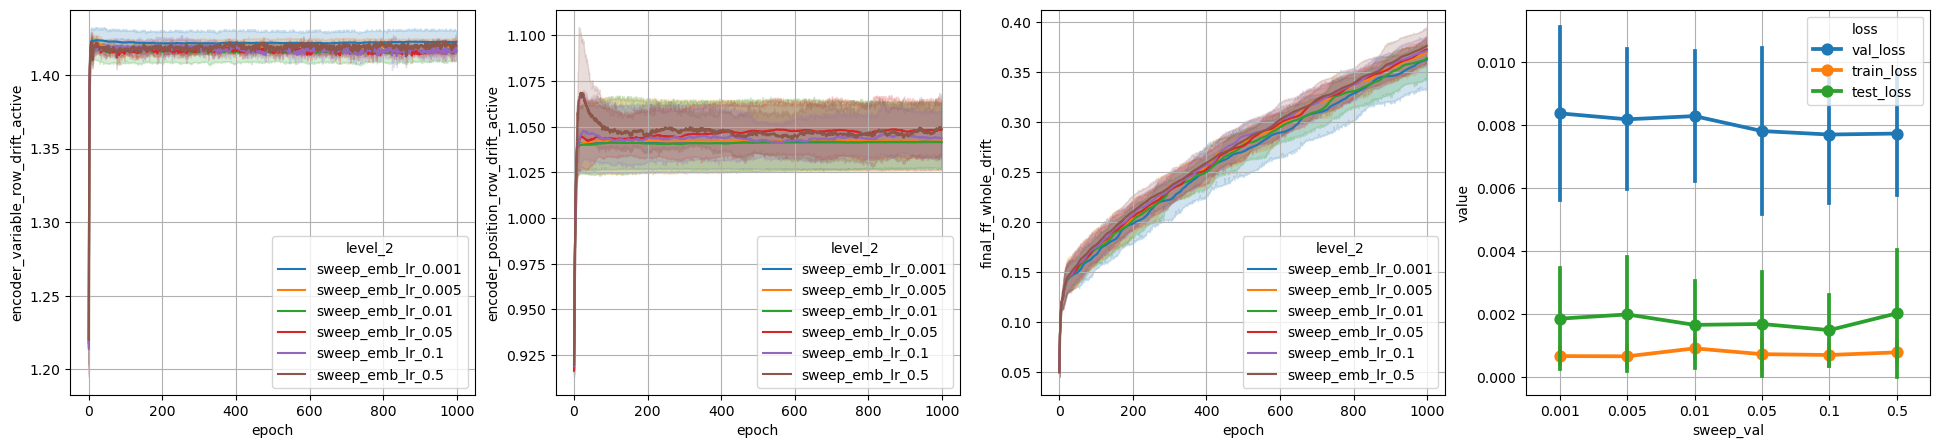

In [5]:
exp_path = "proT/optimizer_experiments/test_opt3_sum/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

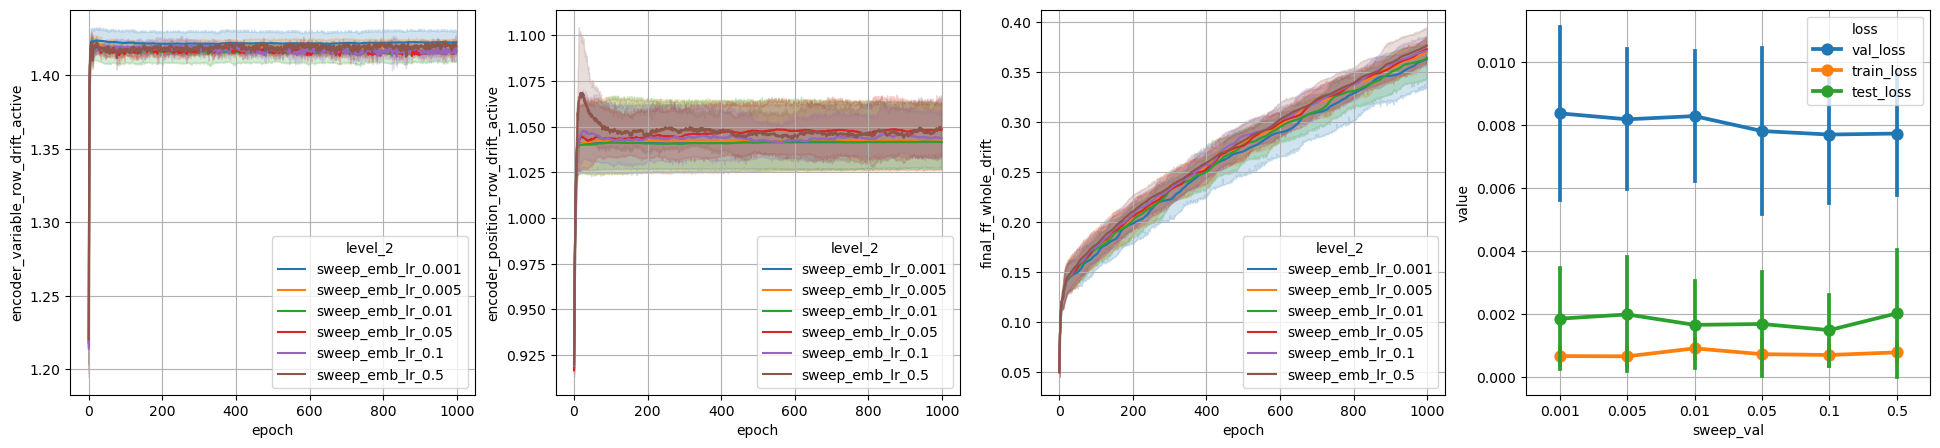

In [6]:
debug_oexp_path = "proT/optimizer_experiments/test_opt4_sum/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

## Concat Embeddings

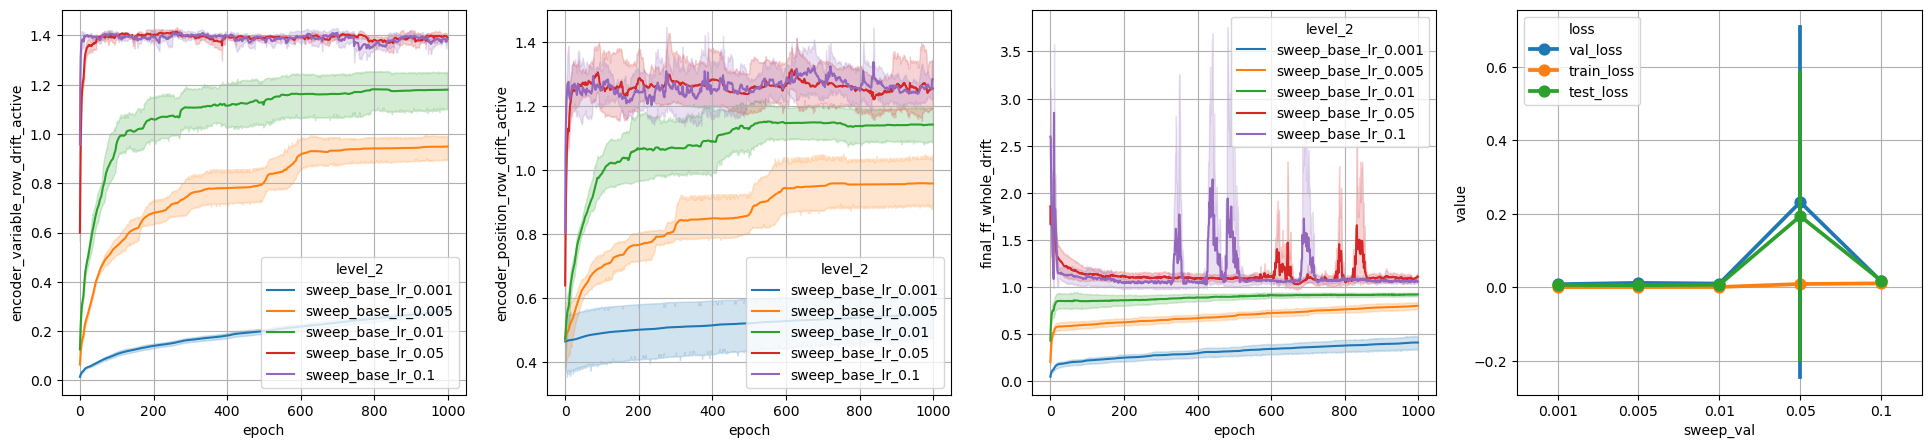

In [7]:
exp_path = "proT/optimizer_experiments/test_opt1_cat/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

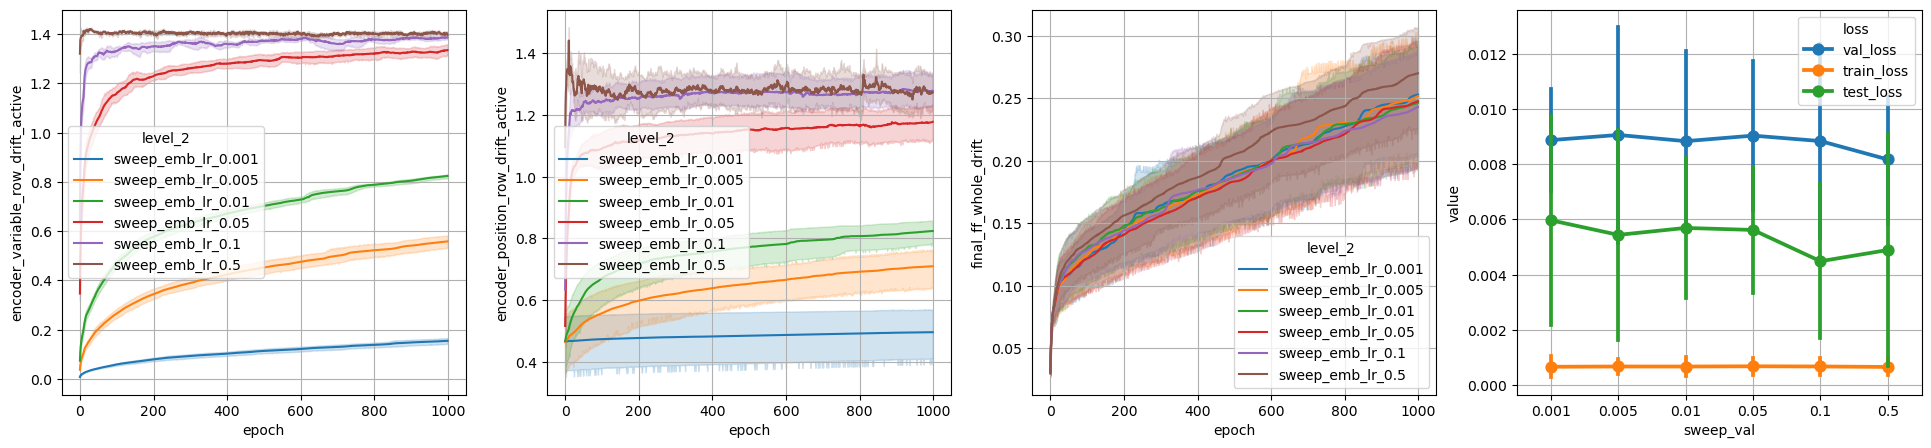

In [8]:
exp_path = "proT/optimizer_experiments/test_opt2_cat/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

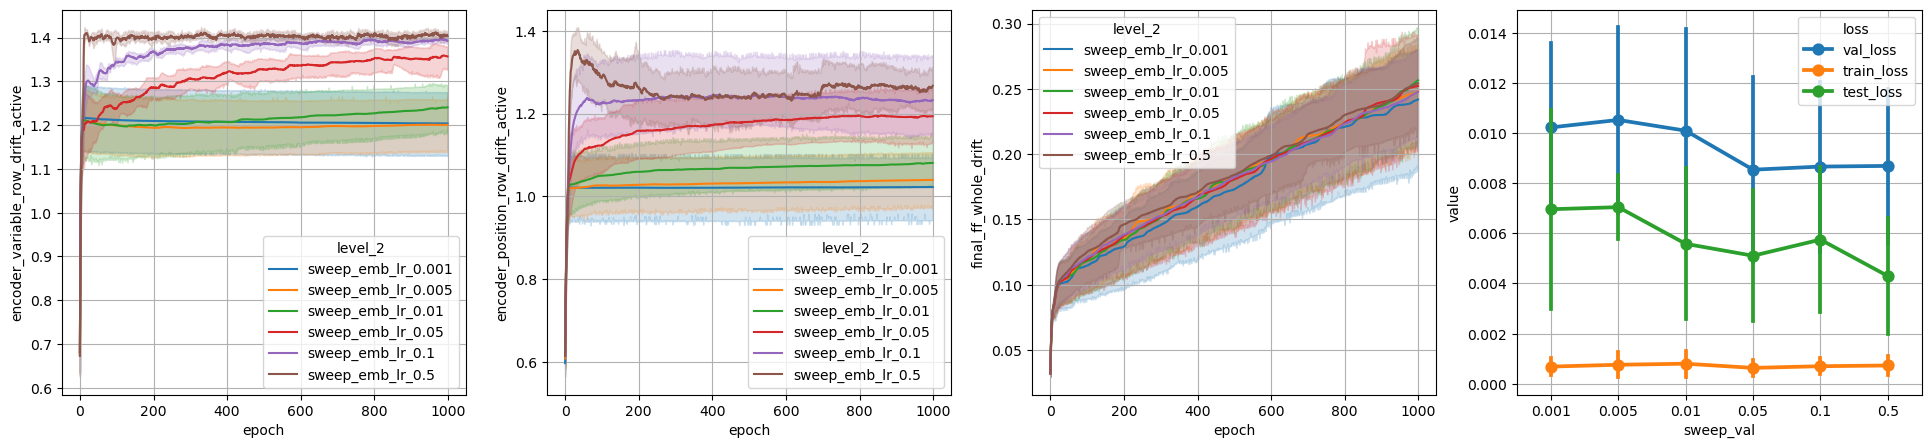

In [9]:
exp_path = "proT/optimizer_experiments/test_opt3_cat/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

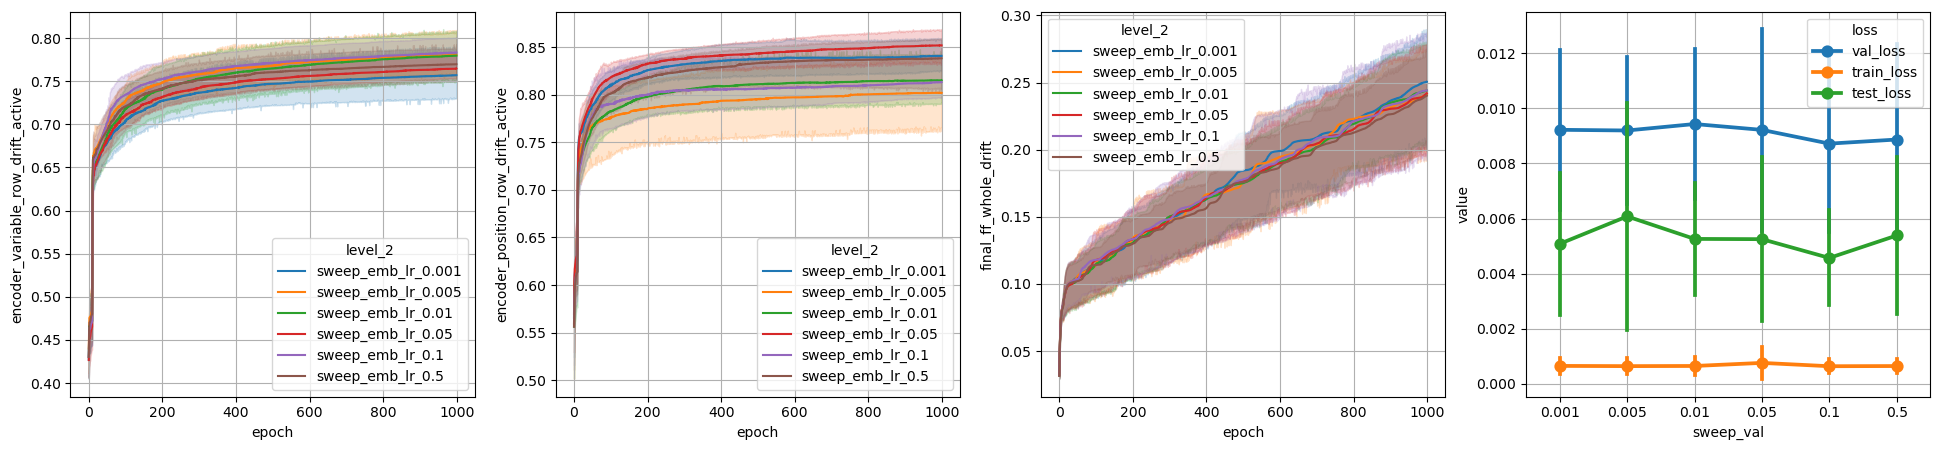

In [10]:
exp_path = "proT/optimizer_experiments/test_opt4_cat/"
debug_opt_mk_plot(dirpath=exp_path, s3_bool=True)

# Observation
1) Losses are stable everywhere: maybe given the small dataset and the large training time, that's the maximum achievable by a given architecture (but then it means that it depends on the architecture!)
2) Using sparse gradients, the embedding drift doesn't depend anymore on the learning rate
3) In all optimizations, the drifts seem to converge to the same values (Q: do they converge to the same representation too?)

# Questions
1) Same stuff for concatenated embeddings?